# X-ray Absorption Spectroscopy Simulation in the Time-Domain 

X-ray absorption spectroscopy (XAS) is a technique for understanding unwanted structures in battery materials. This demo will show you how to implement an algorithm developed in the paper "Fast simulations of X-ray absorption spectroscopy for battery materials on a quantum computer" [Fomichev:2025].  XAS was identified as a potential application for early fault-tolerant quantum computers. X-rays are high energy, and so are short wavelength. Therefore, they probe a very localized grouping of atoms in a materials. We only need to simulate a small number of molecular orbitals to estimate the energy of the orbitals, and the ones accessible by X-rays. However, there is a large amount of correlations between these molecular states. This is the sweet spot between not having to require too many qubits, but having enough correlations that make the calculation intractible on a quantum computer. The ground state is computable, but the highly correlated high-energy states are very difficult to compute in a quantum chemistry classical computation

In this demo we will implement a simplified version of the algorithm as it appears in the paper - we will not be applying all of the optimizations present. We will show how to determine and prepare a group state, how calculate the states that result from acting on the group state by the dipole operator (representing the electromagnetic field from the X-ray) and how to code the time-domain analysis circuit which can estimate the spectrum.

We will be using concepts that were introduced in other PennyLane demos, such as utilizing pyscf with PennyLane, initial state preparation of molecules, and building compressed double-factorized Hamiltonians. If you haven't checked out those demos yet, it might be best to do so and then come back here.

## Why simulate X-ray absorption spectroscopy?

- method for studying local electronic structure
- can directly probe local structure by exciting tightly bound core electrons
- determining battery degredation relevant mechanisms, such as oxidation states, from an observed spectrum is difficult without simulations
- the way one could do this is through spectral fingerprinting
- each oxidized state would have some spectrum, that one would determine through simulation
- this could be repeated for all possible oxidized states
- the observed spectrum could then be matched to combinations of these single cluster spectra
- this "fingerprinting" method could allow one to determine the composition of oxidized states in the material

This method is particularly difficult for classical computers when strongly-correlated transition metals are present, such as those typically in lithium-excess materials which are battery cathod candidates.

![alt text](XAS_notebook/fingerprinting.png)

## Algorithm

### Absorption cross-section

In XAS experiments, the spectrum observed is a measure of the absorption cross section as a function of the frequency of the incident X-rays $\sigma_A(\omega)$. For our situation, the electrons in the molecular cluster start in a ground molecular state $|I\rangle$ with energy $E_I$, and will be coupled to an excited state $|F\rangle$ with energy $E_F$ through the action of the dipole operator $\hat m_\rho$, which represents the effect of the radiative field, where $\rho$ is any of the Cartesian directions $\{x,y,z\}$. 

Using Fermi's golden rule, the absorption cross-section is given by

$$ \sigma_A(\omega) = \frac{4 \pi}{3 \hbar c} \omega \sum_{F \neq I}\sum_{\rho=x,y,z} \frac{|\langle F|\hat m_\rho|I \rangle|^2 \eta}{((E_F - E_I)-\omega)^2 + \eta^2}\,, $$

where $c$ is the speed of light, $\hbar$ is Plank's constant, and $\eta$ is the line broadening which here is set by the experimental resolution of the spectroscopy, and is typically around $1$ eV. In general, it could also be related to the lifetime of the excited states.

What is the intuition behind the expression for the absorption cross section? We expect absorption at an X-ray frequency $\omega \approx E_F - E_I $ when there is an excited state with energy $E_F$ such that the overlap between $\hat m_\rho |I\rangle$ and $|F\rangle$ is significant. The rate of that absorption, by Fermi's golden rule, is proportional to the matrix element squared (the overlap) and the density of final states. Due to experimental resolution and excited state lifetime, the density of the final states could be approximated as a Lorentzian with width $\eta$. The full absorption spectrum would look like a sum of those Lorentzian features weighted by the overlap of the final states and the dipole operator applied to the initial state.

### Core-valence separation approximation

We can restrict the range of frequencies, and consequently the range of final states in our calculation, by only considering final states for which *core* electrons are excited, i.e. there exists a hole in the core orbitals. These are known as core-excited states, and lie significally above the valance-excited states in energy. Typically the frequency range is focused on a target atom in a molecular cluster, and also near a transition energy, such as targetting core $1s$ electrons. We will also neglect relativistic corrections, and focus on frequencies for which the dipole approximation is valid, which is the assumption that the wavelength of the radiation is large compared to the extent of the electronic wavefunction.

Atomic species and oxidations states will determine the energy difference between states with different principle quantum numbers, and this difference will show as a peak in spectroscopy, known as the *absorption edge*. Focusing spctroscopy near this edge for $1s$ to $2p$ is called the $K$-edge, and in general X-ray absorption near-edge spectroscopy is known as XANES. We will focus on simulating spectroscopy in this XANES regime.

![alt text](XAS_notebook/core-valence.png)

### Time-domain determination of the cross section
Next, I'll describe a rough outline of the time-domain algorithm. We start by preparing the state $\hat m_\rho|I\rangle$ and let it evolve for various times given the electronic Hamiltonian $H$. The expectation value $\langle I|\hat m_\rho e^{-i \hat H t} \hat m_\rho |I\rangle$ of that evolved state at various times $t$ will oscillate as a sum of frequency components corresponding to the eigen energies of the Hamiltonian, however, the weight of those components will be related to the overlap with the inital state. Therefore, if we determine this time-domain oscilation of the expectation value, we can take its Fourier transform to obtain a frequency spectrum, which will be related to the absorption spectrum we wish to obtain!

To see how this works more rigorously, we can use a mathematical trick known as a *frequency-domain Green's function* to link the absorption cross section to the frequency components of the expectation value oscillations.

**Insert intuition for using a Green's function**
<!-- A Green's function is an impulse reponse -->

**Insert derivation of relation between cross section and Green's function, i.e. expectation value of time evolution operator for various times**

Below is a step-by-step process of the algorithm:
- determine our initial state $|I\rangle$
- determine how the dipole operator acts on that state to obtain $\hat m_\rho|I\rangle$
- determine how best to efficiently time propagate that state with the molecular Hamiltonian
- run the time propagation for various times, measure the expectation value using a Hadamard test circuit, which gives the time-domain Green's function
- Fourier transform (classically) the Green's function to obtain it in the freuency domain, which gives us the absorption cross section as a function of frequency

![alt text](XAS_notebook/block_diagram_of_algorithm.png)

## Implementation
Let's look at how to implement these steps in PennyLane. We will make extensive use of the `qml.qchem` module, as well as modules from `pyscf`. 

For this demo, we are going to use the very simple $H_2$ molecule. 

### Initial state preparation
If you haven't, check out the demo "Initial state preparation for quantum chemistry". 

We start by creating our molecule object using the Gaussian type orbitals module (`pyscf.gto`), and obtaining the reduced Hartree-Fock molecular orbitals with the self-consistent field methods (`pyscf.scf`).

In [85]:
from pyscf import gto, scf, mcscf
import numpy as np

# Create a mol object
r = 0.71
geom = [['H', (0, 0, 0)],
        ['H', (0, 0, r)]]
basis = '631g'
mol = gto.Mole(atom=geom, basis=basis, symmetry=None)
mol.build()

# get MOs
hf = scf.RHF(mol)
hf.run()

charges = hf.mol.atom_charges()
coords = hf.mol.atom_coords()
nuc_charge_center = np.einsum('z,zx->x', charges, coords) / charges.sum()
print("nuc charge centre", nuc_charge_center)
hf.mol.set_common_orig_(nuc_charge_center)

converged SCF energy = -1.12652193546995
nuc charge centre [0.         0.         0.67085277]


Next we will use the multiconfigurational self-consistent field methods (`pyscf.mcscf`) to solve for the expansion of the intitial wavefunction as a linear combination of Slater determinants. Running the configuration interaction (CI) method returns the wavefunction as as vector. We will filter out small values in the wavefunction. **Explain the shape of this vector.**

In [86]:
ncas = hf.mol.nao
nelecas = hf.mol.nelectron

mycasci = mcscf.CASCI(hf, ncas=ncas, nelecas=nelecas)
mycasci.run(verbose=0)

ncas_a = mycasci.ncas
ncas_b = ncas_a
nelecas_a, nelecas_b = mycasci.nelecas

ground_state = mycasci.ci

# ground state energy
E_i = mycasci.e_tot
print("E_i: ", np.round(E_i, 4), 'Ha')

# filter out small values
ground_state[abs(ground_state) < 1e-6] = 0
print("ground_state: ", ground_state)

E_i:  -1.1508 Ha
ground_state:  [[ 0.99327285  0.          0.00485881  0.        ]
 [ 0.         -0.07091585  0.         -0.04359152]
 [ 0.00485881  0.         -0.05193492  0.        ]
 [ 0.         -0.04359152  0.         -0.04283796]]


### Dipole operator action

The dipole operator $\hat m = -q \cdot \hat r$ will only affect the spatial component of the wavefunction -- it does not care about spin. First, we determine the action of the dipole operator in the atomic orbital basis, then we will transform to the molecular orbitals. We use two resolutions of identity to introduce the atomic orbital wavefunctions $|k\rangle$

$$ \hat m_\rho = -q \cdot \hat r= -q \sum_{ij} |i\rangle \langle i| \hat r |j\rangle \langle j|\,. $$

Then, we simplify by noticing that $|i\rangle \langle j| = c_i^\dagger c_j$ where $c_k^{(\dagger)}$ is the annihilation (creation) operator for orbital $k$. That gives us

$$ \hat m = -q \sum_{ij} \langle i|\hat r |j\rangle c_i^\dagger c_j\,. $$

To calculate the matrix elements $\langle i|\hat r |j\rangle$, we again insert sums over basis states, this time in the position basis, to this as an integral of orbitals 

$$ \langle i|\hat r |j\rangle = \int d^3r' d^3r'' \langle i|r'\rangle \langle r' |\hat r | r'' \rangle \langle r'' | j \rangle = \int d^3r' d^3r'' \phi_i(r') \rho \phi_j^*(r'') \,, $$

where $\phi_k(r)$ are the atomic orbital spatial wavefunctions. These matrix elements can be computed in `pyscf` using the the `intor` method of the `mol` object with argument `'int1e_r_cart'` to specify a one-electron integral with a position $r$ factor. Keyword argument `comp=3` will give us all three components.

In [22]:
dip_ints = hf.mol.intor('int1e_r_cart', comp=3)

We can then transform to the molecular orbital space using `np.einsum` and the `mo_coeff` method of `hf`. 

In [23]:
orbcas = hf.mo_coeff
dip_ints = np.einsum('ik,xkl,lj->xij', orbcas.T, dip_ints, orbcas)

What's left is to code the action of the ladder operators $c_i^\dagger c_j$.

**Explain the above, and insert code below to actually compute `dipole_rho`. Right now I'm just inputting the result.**

In [24]:
## INSERT CODE ##
dipole_rho = {(2, 1): -0.6902564137617815, (1, 2): -0.6902564137617815,
                (8, 1): -0.1327113674508237, (1, 8): -0.1327113674508237,
                (2, 4): -0.07024799874988287, (8, 4): 0.031606880290424764,
                (4, 2): -0.07024799874988287, (4, 8): 0.03160688029042472}

dipole_norm = 1.3058

Finally, we can convert our vector into a PennyLane state vector using `qchem.convert._wfdict_to_statevector`, so that it is ready to be initialized in a circuit. 

In [25]:
from pennylane.qchem.convert import _wfdict_to_statevector

wf_dip = _wfdict_to_statevector(dipole_rho, ncas)

In [87]:
print(wf_dip)

[ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.03160688+0.j  0.        +0.j
  0.        +0.j  0.03160688+0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
 -0.070248  +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
 -0.070248  +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.     

Let's prepare the circuit that will initialize our qubit register with this state

In [26]:
import pennylane as qml

# initialization circuit for m_rho|I>
device_type = "lightning.qubit"

dev_prop = qml.device(device_type, wires=int(2*ncas) + 1, shots=None)
@qml.qnode(dev_prop)
def initial_circuit(wf):
    # dipole wavefunction preparation
    qml.StatePrep(wf, wires=dev_prop.wires.tolist()[1:])
    qml.Hadamard(wires=0)
    return qml.state()

### Molecular Hamiltonian

Go read the demo "How to build compressed double-factorized Hamiltonians" if you haven't, because that is exactly what we are going to do!

Compressed double-factorized (CDF) molecular Hamiltonians will be perfect for our application -- time propagating our state with an electronic Hamiltonian. We will approximate the evolution operator $e^{-iHt}$ with a Trotter product formula, where the factorized Hamiltonian will allow much faster simulation.

Our electronic Hamiltonian is

$$ H = E + \sum_{p,q=1}^N \sum_{\gamma\in\{\uparrow,\downarrow\}} (p|\kappa|q) a^\dagger_{p\gamma}a_{q\gamma} + \frac12 \sum_{p,q,r,s=1}^N\sum_{\gamma,\beta\in\{\uparrow,\downarrow\}} (pq|rs) a^\dagger_{p\gamma}a_{q\gamma} a^\dagger_{r\beta}a_{s\beta} \,, $$

where $a^{(\dagger)}_{p\gamma}$ is the annihilation (creation) operator for a spatial orbital $p$ and spin $\gamma$, $E$ is the enrgy offset, $N$ is the number of spatial orbitals, and $(p|\kappa|q)$ and $(pq|rs)$ are the one- and two-electron integrals, respectively. 

Luckily, the one- and two- electron integrals can be computed using modules in `pyscf`. The core constant can also be obtained using the method `energy_nuc()` of the `mol` object.

In [27]:
from pyscf import ao2mo

# create h1 -- one-body terms
h_core = hf.get_hcore(mol)
orbs = hf.mo_coeff
core_const = mol.energy_nuc()
one = np.einsum("qr,rs,st->qt", orbs.T, h_core, orbs)

# create h2 -- two-body terms
two = ao2mo.full(hf._eri, orbs, compact=False).reshape([mol.nao]*4)
two = np.swapaxes(two, 1, 3)

# to chemist notation
eri = np.einsum('prsq->pqrs', two)
h1e = one - np.einsum('pqrr->pq', two)/2.

We can apply CDF to the two-electron integrals using `qml`'s `qchem.factorize` function, with `compressed=True`. 

In [28]:
# factorize hamiltonian, producing matrices
_, Z, U = qml.qchem.factorize(eri, compressed=True, num_steps=10000)

print("Shape of the factors: ")
print("eri", eri.shape)
print("U", U.shape)
print("Z", Z.shape)

approx_eri = qml.math.einsum("tpk,tqk,tkl,trl,tsl->pqrs", U, U, Z, U, U)
assert qml.math.allclose(eri, approx_eri, atol=1.5e-3)

Shape of the factors: 
eri (4, 4, 4, 4)
U (8, 4, 4)
Z (8, 4, 4)



**Explain one-body extra term as the one-qubit Pauli-Z terms.** Finally, we add the one-body correction to the one-electron integrals, and use `np.linalg.eigh` to diagonalize them into the matrix $Z^{(0)}$ and obtain the rotation matrices $U^{(0)}$.

In [29]:
# add one-body correction
Z_prime = np.stack([np.diag(np.sum(Z[i], axis = -1)) for i in range(Z.shape[0])], axis = 0)
obc = np.einsum('tpk,tkk,tqk->pq', U, Z_prime, U)

# Diagonalize the one-electron integral matrix
eigenvals, U0 = np.linalg.eigh(h1e + obc)
Z0 = np.diag(eigenvals)

**I think I need to explain the Jordan-Wigner mapping here explicitly, showing the one-body extra, and the new rotation matrices and how they can be implemented with Thouless' theorem.**

**Explain simplification using Thouless' theorem (here or in earlier section)**
Specifically how to go form what looks like two U rotations to just one when using the `qml.BasisRotation`.

### Time-propagation circuit

The main work of our algorithm will be to apply our Hamiltonian terms as a trotter product, and measure the expectation value of that time evolution for various times. Let's start by writing functions that implement the time evolution for each Hamiltonian term, which will be called by our trotter circuit. One thing to track throughout this implementation is the global phase accrued throughout the time evolution. Starting with the $U$ operator rotations, we can write a function that uses `qml.BasisRotation` to apply the unitary transform we want. We apply this to both spin sections of the register.

In [30]:
def U_rotations(U, control_wires):
    """Circuit implementing the basis rotations of the CDF decomposition."""
    norb = U.shape[-1]
    qml.BasisRotation(unitary_matrix=U, wires = [int(2*i+control_wires) for i in range(norb)])
    qml.BasisRotation(unitary_matrix=U, wires = [int(2*i+1+control_wires) for i in range(norb)])

Next we write a function to perform the $Z$ rotations. To simplify the Trotter function, we condition the action in the function on whether it's acting for a one-body or a two-body term.

In [31]:
from itertools import product

def Z_rotations(Z, step, is_one_body_term, control_wires):
    """Circuit implementing the Z rotations of the CDF decomposition. 
    Note that t will range from t = 1 to t = ts, so we use t-1 in the code."""
    norb = Z.shape[-1]

    if is_one_body_term:
        for sigma in range(2):
            for i in range(norb):
                if abs(Z[i, i]) > 1e-15:
                    qml.ctrl(qml.X(wires=int(2*i+sigma+control_wires)),
                                        control = range(control_wires), control_values=0)
                    qml.RZ(-Z[i, i]*step/2, wires=int(2*i+sigma+control_wires))
                    qml.ctrl(qml.X(wires=int(2*i+sigma+control_wires)),
                                        control = range(control_wires), control_values=0)
        globalphase = np.sum(Z)*step

    else:  # a two body term
        for sigma, tau in product(range(2), repeat=2):
            for i, k in product(range(norb), repeat=2):
                if (i != k or sigma != tau) and abs(Z[i, k]) > 1e-15:  # Two body term
                    qml.ctrl(qml.X(wires=int(2*i+sigma+control_wires)), 
                            control = range(control_wires), control_values=0)
                    qml.MultiRZ(Z[i, k]/8.*step,
                            wires=[int(2*i+sigma+control_wires), int(2*k+tau+control_wires)])
                    qml.ctrl(qml.X(wires=int(2*i+sigma+control_wires)),
                            control = range(control_wires), control_values=0)
        globalphase = np.trace(Z)/4.*step - np.sum(Z)*step + np.sum(Z)*step/2.

    qml.PhaseShift(-globalphase, wires = 0)

Let's define our Trotter step. The function will implement $U$ rotations and $Z$ rotations. By tracking the last $U$ rotation used, we can implement two consequtive rotations at once as $V^{(\ell)} = U^{(\ell-1)}(U^{(\ell)})^T$, halving the number of rotations required per Trotter step. 

We will write a function `LieTrotter` which will apply the rotations for the one- and two- body terms in one order, but can also reverse the order. This can save another rotation step when we implement two consecutive Trotter steps in the second-order Trotter scheme.

In [32]:
def LieTrotter(step, prior_U, final_rotation, reverse=False):
    """Implements a first-order Trotterized circuit for the CDF."""
    _U0 = np.expand_dims(U0, axis = 0)
    _Z0 = np.expand_dims(Z0, axis = 0)
    _U = np.concatenate((_U0, U), axis = 0)
    _Z = np.concatenate((_Z0, Z), axis = 0)

    ts = U.shape[0]
    is_one_body = np.array([True] + [False]*ts)
    order = list(range(len(_Z)))

    if reverse: order = order[::-1]

    for t in order:
        U_rotations(prior_U @ _U[t], 1)
        Z_rotations(_Z[t], step, is_one_body[t], 1)
        prior_U = _U[t].T

    if final_rotation: U_rotations(prior_U, 1)

    qml.PhaseShift(-core_const*step, wires=0)

    return prior_U

Our function `trotter_circuit` implements a second-order Trotter step, returning the Trotter step `circuit` which applies `StatePrep` to prepare the register in the previous quantum state, and two `LieTrotter` calls.

In [33]:
def trotter_circuit(dev, state, step):
    """Implements a second-order Trotterized circuit for the CDF."""
    qubits = dev.wires.tolist()

    def circuit():
        # State preparation -- previous iteration
        qml.StatePrep(state, wires=qubits)

        # Main body of the circuit
        prior_U = np.eye(ncas)  # no inital prior U, so identity
        prior_U = LieTrotter(step/2., prior_U=prior_U, 
                        final_rotation=False, reverse=False)
        prior_U = LieTrotter(step/2., prior_U=prior_U, 
                    final_rotation=True, reverse=True)

        return qml.state()

    return qml.QNode(circuit, dev)

### Simulation parameters

Let's discuss our choice of parameters when running this simulation.
**Discuss $\eta$, $j_\mathrm{max}$, the total number of shots $S$, the Hamiltonian norm $||H||$, the grid of frequencies and the time step $\tau$**.

In [34]:
eta = 0.05  # Ha
jmax = 40
shots = 1000
norm = 1.5
wgrid = np.linspace(-2, +5, 10000)
w_min, w_step = wgrid[0], wgrid[1] - wgrid[0]

tau = np.pi / (2 * norm)
jrange = np.arange(1, 2*int(jmax)+1, 1)
time_interval = tau * jrange

print(f"tau: {tau:.4}")
print(f"time int: {len(time_interval)}")
print(f"w_step: {w_step:.2} Ha")

tau: 1.047
time int: 80
w_step: 0.0007 Ha


### Measurement

To measure the expectation value of the time-propagated state, we use a Hadamard test. 

In [35]:
# measurement circuit
dev_est = qml.device(device_type, wires=int(2*ncas) + 1, shots=shots)

@qml.qnode(dev_est)
def meas_circuit(state):
    qml.StatePrep(state, wires=dev_est.wires.tolist())
    # measure in PauliX or PauliY to get the real/imag parts
    return [qml.expval(op) for op in \
            [qml.PauliX(wires=0), qml.PauliY(wires=0)]]

## Run Simulation
Finally, we can run the simulation, and calculate the spectrum from the measurement results.

In [39]:
# grab an initial state (including the auxiliary qubit)
state = initial_circuit(wf_dip)

expvals = np.zeros((2, len(time_interval)))  # results list initialization

# perform time steps
for ii in range(0, len(time_interval), 1):

    circuit = trotter_circuit(dev=dev_prop, state=state, step=tau)

    # update state and then measure
    state = circuit()
    measurement = meas_circuit(state=state)
    
    expvals[:, ii] += np.array(measurement).real

Plotting the time-domain output we see

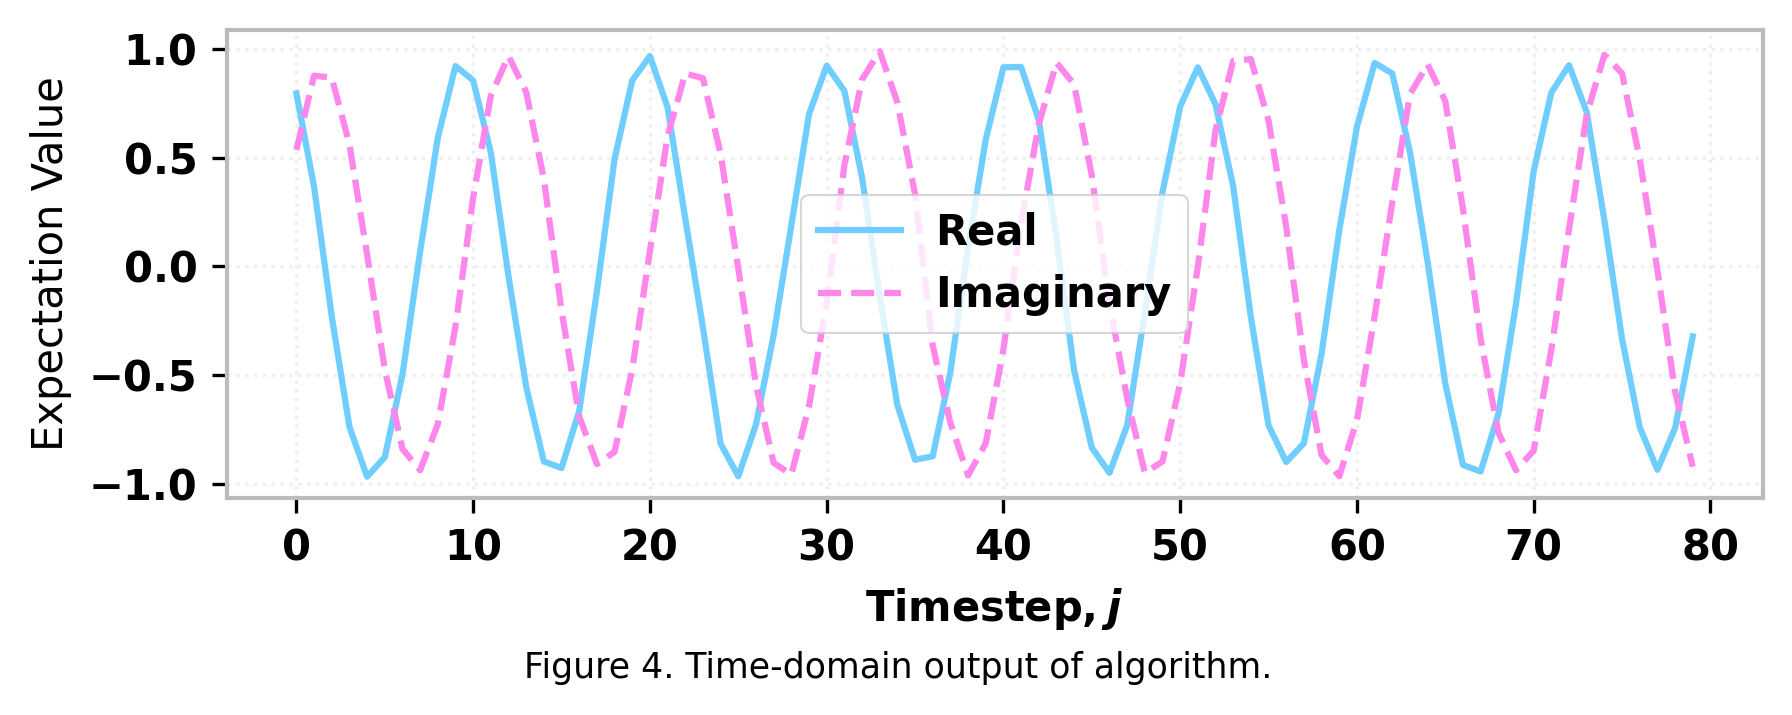

In [40]:
import matplotlib.pyplot as plt
plt.style.use("pennylane.drawer.plot")

fig = plt.figure(figsize=(6.4, 2.4))
ax = fig.add_axes((0.15, 0.3, 0.8, 0.65))
ax.plot(range(len(results[0, :])), expvals[0, :], label="Real")
ax.plot(range(len(results[1, :])), expvals[1, :], label="Imaginary", linestyle="--")
ax.set(xlabel=r"$\mathrm{Time step}, j$", ylabel=r"Expectation Value")
fig.text(0.5, 0.05,
    "Figure 4. Time-domain output of algorithm.",
    horizontalalignment="center",
    size="small",
    weight="normal",
)
ax.legend()
plt.show()

We can now Fourier transform the output to determine the spectrum.

In [42]:
L_j = np.exp(-eta * time_interval)
normalized_f_domain_Greens_func = lambda w: tau/(2.*np.pi) * (1 + 2*np.sum(L_j * \
                (expvals[0,:] * np.cos(time_interval*w) \
                - expvals[1,:] * np.sin(time_interval*w))))

normalized_f_domain_Greens_array = np.array([normalized_f_domain_Greens_func(w) for w in wgrid])
normalized_f_domain_Greens = lambda w: normalized_f_domain_Greens_array[int((w-w_min)//w_step)]

f_domain_Greens = lambda w: dipole_norm**2 * normalized_f_domain_Greens(w)
spectrum = np.array([f_domain_Greens(w) for w in wgrid]) 

Let's also make a classical reference since $H_2$ is such a simple system. We can do this using the CASCI module like we used to determine the ground state, but instead solve for more states. To do this, we will reuse the `mycasci` instance we created earlier. We can then also solve for the transition density matrix in the molecular orbital basis, $\langle F| \hat m_\rho |I \rangle$.

In [82]:
# solve for excited states
mycasci.fcisolver.nroots = 250
mycasci.run(verbose=0)
mycasci.e_tot = np.atleast_1d(mycasci.e_tot)

def makedip(ci_id):
    """Determines the transition dipole matrix elements, and then converts
    to the molecular orbital basis."""
    # transition density matrix in MO representation
    t_dm1 = mycasci.fcisolver.trans_rdm1(ground_state, \
                            mycasci.ci[ci_id], ncas, nelecas)
    print(t_dm1)
    # transition dipole moments
    return np.einsum('xij,ji->x', dip_ints, t_dm1)

F_m_Is = np.array([makedip(i) for i in range(len(mycasci.e_tot))])

spectrum_classical_func = lambda w: (1./np.pi) * np.sum( \
        [ np.sum(np.abs(F_m_Is)**2) * eta / ( (E_F-E_i-w)**2 + eta**2) \
                        for (tm, E_F) in zip(tms, mycasci.e_tot) ] )

spectrum_classical = np.array([spectrum_classical_func(w) for w in wgrid])

[[1.97322913 0.         0.00914756 0.        ]
 [0.         0.01385856 0.         0.0099174 ]
 [0.00914756 0.         0.00544169 0.        ]
 [0.         0.0099174  0.         0.00747062]]
[[ 4.60288181e-17 -8.32667268e-17  6.90306051e-18 -3.46944695e-17]
 [ 8.88178420e-16 -3.79433956e-17  1.95156391e-17 -2.18582682e-17]
 [-1.27244541e-16 -4.85722573e-17 -5.05121114e-18 -2.64545330e-17]
 [ 3.46944695e-16 -6.61869340e-19  1.51788304e-17 -3.03421135e-18]]
[[-5.83572004e-17 -9.74752304e-02 -2.50205101e-17 -5.93009424e-02]
 [ 1.38972425e+00  9.44855951e-17 -3.78125352e-03  7.02713789e-17]
 [ 4.75679912e-16 -1.23628432e-02 -2.79387808e-17 -6.83518958e-03]
 [-3.83998091e-02  1.18489696e-17  2.28716493e-03 -8.18961390e-18]]
[[-9.28077060e-17  2.84860462e-17 -5.55111512e-17  3.48162829e-17]
 [ 2.61732307e-16  1.46584134e-16 -2.08568366e-17  1.02782366e-16]
 [ 9.99200722e-16 -5.12459626e-17 -9.80118764e-17 -3.92407730e-17]
 [-1.06916179e-15  6.59194921e-17 -3.02990725e-17  4.33680869e-17]]
[[-1

In [81]:
print(F_m_Is)

[[ 0.00000000e+00  0.00000000e+00 -9.33073331e-16]
 [ 0.00000000e+00  0.00000000e+00 -3.75256772e-16]
 [ 0.00000000e+00  0.00000000e+00  1.27417942e+00]
 [ 0.00000000e+00  0.00000000e+00  3.53952444e-16]
 [ 0.00000000e+00  0.00000000e+00  6.88790335e-16]
 [ 0.00000000e+00  0.00000000e+00 -4.64091459e-16]
 [ 0.00000000e+00  0.00000000e+00 -8.71489601e-16]
 [ 0.00000000e+00  0.00000000e+00 -2.15369079e-01]
 [ 0.00000000e+00  0.00000000e+00  1.41358613e-16]
 [ 0.00000000e+00  0.00000000e+00 -1.85017838e-01]
 [ 0.00000000e+00  0.00000000e+00  2.26781765e-16]
 [ 0.00000000e+00  0.00000000e+00  1.45217719e-16]
 [ 0.00000000e+00  0.00000000e+00  5.09888465e-16]
 [ 0.00000000e+00  0.00000000e+00 -1.52705708e-16]
 [ 0.00000000e+00  0.00000000e+00 -3.10599421e-02]
 [ 0.00000000e+00  0.00000000e+00 -1.20706985e-15]]


Let's plot and compare the classical and quantum spectra.

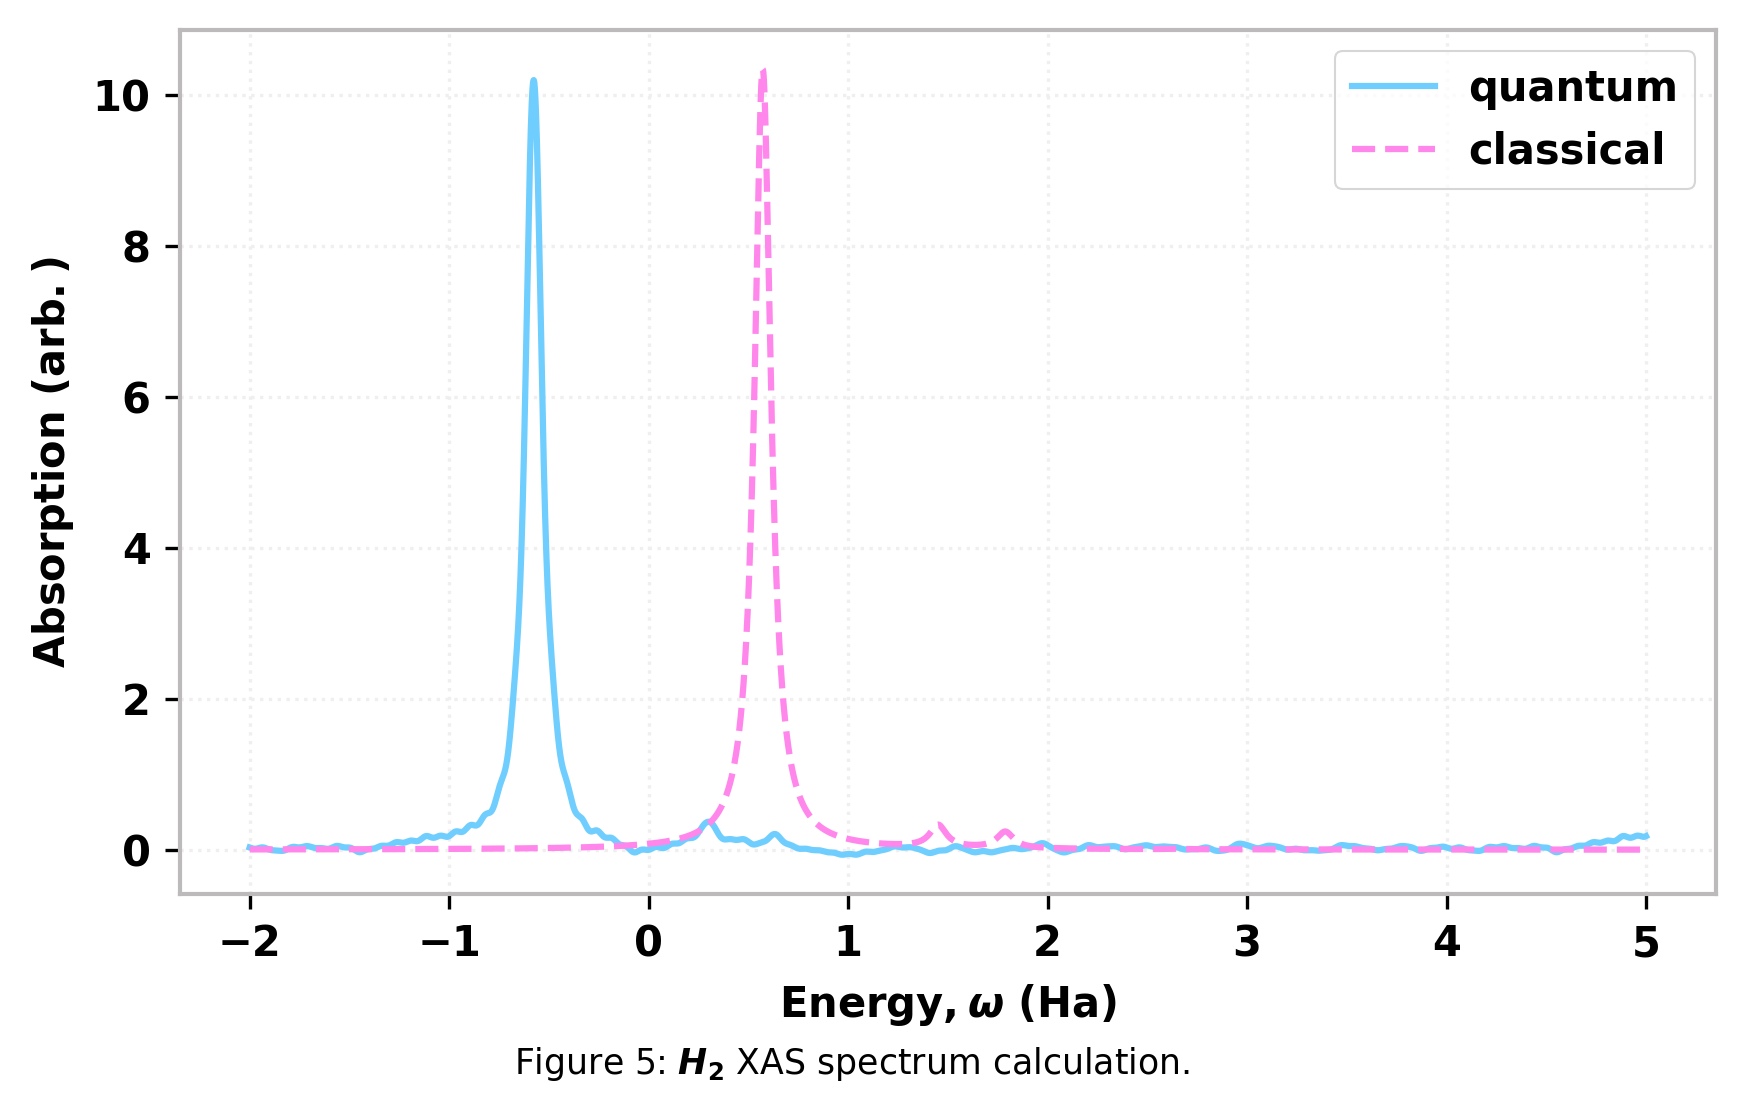

In [63]:
fig = plt.figure(figsize=(6.4, 4))
ax = fig.add_axes((0.15, 0.20, 0.80, 0.72))  # make room for caption

ax.plot(wgrid, spectrum.real, label='quantum')
ax.plot(wgrid, spectrum_classical, '--', label='classical')
ax.set_xlabel(r"$\mathrm{Energy}, \omega\ (\mathrm{Ha})$")
ax.set_ylabel(r"$\mathrm{Absorption\ (arb.)}$")
ax.legend()

fig.text(0.5, 0.05,
    r"Figure 5: $H_2$ XAS spectrum calculation.",
    horizontalalignment="center",
    size="small",
    weight="normal",
)

plt.show()

**Describe AO and MO character of these absorption peaks. They should be the |0> to |2>, |7> and |9> transitions.**

### Further Optimizations

There are more optimizations mentioned in the paper that were not implemented here. Below is a list of further optimizations:
- Randomized Trotter steps
- BLISS
- Distribution sampling
- Double measurement

## Conclusion
In this tutorial, we have implemented a simplified version of the algorithm as presented in [Fomichev:2025]. The algorithm represents a culmination of many optimizations for time-evolving an electronic Hamiltonian. We've also discussed how XAS is a promising candidate for early fault-tolerant quantum computers due to its low qubit overhead but high amount of correlations in the state space. 